In [ ]:
!pip install urllib3
!pip install spacy
!python3 -m spacy download en_core_web_sm
!pip install nltk
!pip install beautifulsoup4
!pip install textacy
!pip install feedparser
!pip install pyLDAvis
!pip uninstall pandas
!pip install pandas==1.3.4

     |████████████████████████████████| 12.0 MB 10.2 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
     |████████████████████████████████| 200 kB 14.0 MB/s 
     |████████████████████████████████| 481 kB 60.4 MB/s 
     |████████████████████████████████| 132 kB 64.8 MB/s 
     |████████████████████████████████| 6.0 MB 43.5 MB/s 
     |████████████████████████████████| 2.0 MB 29.2 MB/s 
     |████████████████████████████████| 181 kB 67.8 MB/s 
     |████████████████████████████████| 10.1 MB 65.7 MB/s 
     |████████████████████████████████| 628 kB 73.8 MB/s 
     |████████████████████████████████| 42 kB 1.2 MB/s 
     |████████████████████████████████| 451 kB 76.3 MB/s 
  Created wheel for cytoolz: filename=cytoolz-0.11.2-cp37-cp37m-linux_x86_64.whl size=1230805 sha256=033b5037e733d6e7203399092a8c4dcc562c71a9b7c9d917614a7a687d33b116
  Stored in directory: /root/.cache/pip/wheels/38/70/71/ca13ea3d36ccd0b3d0ec7d7a4ca67522048d695b5

Found existing installation: pandas 1.3.5
Uninstalling pandas-1.3.5:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/pandas-1.3.5.dist-info/*
    /usr/local/lib/python3.7/dist-packages/pandas/*
Proceed (y/n)? y
  Successfully uninstalled pandas-1.3.5
     |████████████████████████████████| 11.3 MB 13.9 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas~=1.1.0; python_version >= "3.0", but you have pandas 1.3.4 which is incompatible.


In [ ]:
# Suppress Warnings
import warnings
warnings.filterwarnings('ignore')


#Import the necessary packages
import pickle
import pandas as pd
import numpy as np
from datetime import datetime
import nltk
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.corpus import stopwords
import gensim
from gensim.utils import simple_preprocess
from gensim.corpora.dictionary import Dictionary
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from gensim.models.ldamodel import LdaModel
#import spacy
import string
import re
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
import matplotlib.font_manager
from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# New Section

In [ ]:
#Load the krebs dataset (saved as a pickle file) into a dataframe df
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/SID 3-1/CS F366/NPR-postcovid-dataset.csv")
print(df.head())

  web-scraper-order  ...                                           Abstract
0     1641462603-87  ...  One, employees are working from their home net...
1     1641462606-92  ...  The most common form of surveillance implement...
2    1641462625-163  ...                                                NaN
3    1641462702-432  ...                                                NaN
4    1641462724-516  ...  The main components of the security tool are t...

[5 rows x 4 columns]


In [ ]:
df = df[["Title", "Abstract"]]

In [ ]:
#Inspect the dataframe
print(len(df.index))
print(df.head())

1244
                                               Title                                           Abstract
0                      Cybersecurity During COVID-19  One, employees are working from their home net...
1        Global Surveillance in the Wake of COVID-19  The most common form of surveillance implement...
2          Traffic Analysis of Home Security Cameras                                                NaN
3                   AI Security Risk Assessment Tool                                                NaN
4  Cobalt Strike Vulnerability Affects Botnet Ser...  The main components of the security tool are t...


In [ ]:
#Set the index to the date column
#from datetime import datetime
#df['Date']=pd.to_datetime(df['Date'],format='%Y-%m-%d')
#df = df.set_index('Date')

In [ ]:



df['Abstract'] = df['Abstract'].replace(np.nan, '')
df['Abstract']

0       One, employees are working from their home net...
1       The most common form of surveillance implement...
2                                                        
3                                                        
4       The main components of the security tool are t...
                              ...                        
1239    The Federal Bureau of Investigation (FBI) conf...
1240    Over the past few weeks, three of the longest ...
1241    Finastra, a company that provides a range of t...
1242    Microsoft today rolled out updates to plug at ...
1243    For the past year, a site called Privnotes.com...
Name: Abstract, Length: 1244, dtype: object

In [ ]:
#Define a function that removes urls from text using regex
def remove_urls(text):
    URLess_string = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', text)
    return URLess_string

In [ ]:
#Define a function that removes punctuation from the text which may impact the model's ability to extract topics
def remove_punctuation(text):
    no_punct = re.sub(r'[^\w\s]', '', text)
    return no_punct

In [ ]:
#Apply the remove url function to the body series
df['Abstract'] = df['Abstract'].apply(lambda x: remove_urls(x))

In [ ]:
#Apply the remove punctuation function to the body series
df['Abstract'] = df['Abstract'].apply(lambda x: remove_punctuation(x))


In [ ]:
data = df.Abstract.values.tolist()

In [ ]:
print(df.head())

                                               Title                                           Abstract
0                      Cybersecurity During COVID-19  One employees are working from their home netw...
1        Global Surveillance in the Wake of COVID-19  The most common form of surveillance implement...
2          Traffic Analysis of Home Security Cameras                                                   
3                   AI Security Risk Assessment Tool                                                   
4  Cobalt Strike Vulnerability Affects Botnet Ser...  The main components of the security tool are t...


Improving Interpretability using n-grams:

In [ ]:
# Added on 25-11
bigram_measures = nltk.collocations.BigramAssocMeasures()
finder = nltk.collocations.BigramCollocationFinder.from_documents([comment.split() for comment in df.Abstract])
# Filter only those that occur at least 10 times
finder.apply_freq_filter(10)
bigram_scores = finder.score_ngrams(bigram_measures.pmi)

In [ ]:
# added on 25-11
trigram_measures = nltk.collocations.TrigramAssocMeasures()
finder = nltk.collocations.TrigramCollocationFinder.from_documents([comment.split() for comment in df.Abstract])
# Filter only those that occur at least 50 times
finder.apply_freq_filter(5)
trigram_scores = finder.score_ngrams(trigram_measures.pmi)


In [ ]:
bigram_pmi = pd.DataFrame(bigram_scores)
bigram_pmi.columns = ['bigram', 'pmi']
bigram_pmi.sort_values(by='pmi', axis = 0, ascending = False, inplace = True)

In [ ]:
trigram_pmi = pd.DataFrame(trigram_scores)
trigram_pmi.columns = ['trigram', 'pmi']
trigram_pmi.sort_values(by='pmi', axis = 0, ascending = False, inplace = True)

In [ ]:
# Filter for bigrams with only noun-type structures
def bigram_filter(bigram):
    tag = nltk.pos_tag(bigram)
    if tag[0][1] not in ['JJ', 'NN'] and tag[1][1] not in ['NN']:
        return False
    if bigram[0] in stopwords.words('english') or bigram[1] in stopwords.words('english'):
        return False
    if 'n' in bigram or 't' in bigram:
        return False
    if 'PRON' in bigram:
        return False
    return True

In [ ]:
def trigram_filter(trigram):
    tag = nltk.pos_tag(trigram)
    if tag[0][1] not in ['JJ', 'NN'] and tag[1][1] not in ['JJ','NN']:
        return False
    if trigram[0] in stopwords.words('english') or trigram[-1] in stopwords.words('english') or trigram[1] in stopwords.words('english'):
        return False
    if 'n' in trigram or 't' in trigram:
         return False
    if 'PRON' in trigram:
        return False
    return True 

In [ ]:
# Can set pmi threshold to whatever makes sense - eyeball through and select threshold where n-grams stop making sense
# choose top 500 ngrams in this case ranked by PMI that have noun like structures
filtered_bigram = bigram_pmi[bigram_pmi.apply(lambda bigram: bigram_filter(bigram['bigram']) and bigram.pmi > 5, axis = 1)][:500]

filtered_trigram = trigram_pmi[trigram_pmi.apply(lambda trigram: trigram_filter(trigram['trigram']) and trigram.pmi > 5, axis = 1)][:500]


bigrams = [' '.join(x) for x in filtered_bigram.bigram.values if len(x[0]) > 2 or len(x[1]) > 2]
trigrams = [' '.join(x) for x in filtered_trigram.trigram.values if len(x[0]) > 2 or len(x[1]) > 2 and len(x[2]) > 2]

In [ ]:
bigrams[:10]

['vice president',
 'USA TODAY',
 'twofactor authentication',
 'COVID19 pandemic',
 'Federal Trade',
 'supply chain',
 'third parties',
 'guest essay',
 'law enforcement',
 'bad guys']

In [ ]:
trigrams[:10]

['distributed denialofservice DDoS',
 'advocacy group Consumer',
 'chief technical officer',
 'senior vice president',
 'denialofservice DDoS attacks',
 'guest blog post',
 'law enforcement agencies',
 'chief technology officer',
 'today released updates',
 'Microsoft today released']

In [ ]:
# Concatenate n-grams
def replace_ngram(x):
    for gram in trigrams:
        x = x.replace(gram, '_'.join(gram.split()))
    for gram in bigrams:
        x = x.replace(gram, '_'.join(gram.split()))
    return x

In [ ]:
reviews_w_ngrams = df.copy()

In [ ]:
reviews_w_ngrams.Abstract = reviews_w_ngrams.Abstract.map(lambda x: replace_ngram(x))

In [ ]:
# tokenize reviews + remove stop words + remove names + remove words with less than 2 characters
# english_names not implemented
reviews_w_ngrams = reviews_w_ngrams.Abstract.map(lambda x: [word for word in x.split() if word not in stopwords.words('english') and len(word) > 2 and word not in ['cybersecurity','information','security','cyber','research','paper','study']])

In [ ]:
reviews_w_ngrams.head()

0    [One, employees, working, home, networks, some...
1    [The, common, form, surveillance, implemented,...
2                                                   []
3                                                   []
4    [The, main, components, tool, Cobalt, Strike, ...
Name: Abstract, dtype: object

In [ ]:
# Filter for only nouns
def noun_only(x):
    pos_comment = nltk.pos_tag(x)
    filtered = [word[0] for word in pos_comment if word[1] in ['NN']]
    # to filter both noun and verbs
    #filtered = [word[0] for word in pos_comment if word[1] in ['NN','VB', 'VBD', 'VBG', 'VBN', 'VBZ']]
    return filtered

In [ ]:
final_reviews = reviews_w_ngrams.map(noun_only)
df['Abstract']=final_reviews
# final_reviews.head()
df.head()

,Title,Abstract
0,Cybersecurity During COVID-19,"[home, date, attack]"
1,Global Surveillance in the Wake of COVID-19,"[form, surveillance, battle, use, smartphone, ..."
2,Traffic Analysis of Home Security Cameras,[]
3,AI Security Risk Assessment Tool,[]
4,Cobalt Strike Vulnerability Affects Botnet Ser...,"[client, team, server, exfiltrate, attacker, m..."


In [ ]:
#Define a function that takes input string, converts it all to lower case then tokenizes it using nltk.tokenize
def word_tokenizer(text):
    tokens = nltk.word_tokenize(text.lower())
    return tokens

In [ ]:
#Apply the tokenizer function to the entire Body series
# df.Body = df.Body.apply(lambda x: word_tokenizer(x))

In [ ]:
df.head()

,Title,Abstract
0,Cybersecurity During COVID-19,"[home, date, attack]"
1,Global Surveillance in the Wake of COVID-19,"[form, surveillance, battle, use, smartphone, ..."
2,Traffic Analysis of Home Security Cameras,[]
3,AI Security Risk Assessment Tool,[]
4,Cobalt Strike Vulnerability Affects Botnet Ser...,"[client, team, server, exfiltrate, attacker, m..."


In [ ]:
#Save the preprocessed data to a pickle file: 'df_preprocessed.pickle'
with open('df_preprocessed.pickle', 'wb') as f:
    pickle.dump(df, f)

In [ ]:
# df.index = pd.to_datetime(df.index)
#df = df.sort_index()

#df.head()

#df = df['2019-12-31':]
# print(df.size())

In [ ]:
# Create a dictionary of all unique tokens by passing df.Body to the Dictionary method
df.count
dictionary = corpora.Dictionary(df.Abstract)


In [ ]:
#Each unique token is mapped to an id number e.g. 'chip': 140
#dictionary.token2id

In [ ]:
#Turn the dictionary into a corpus (a Bag of Words) that contains the word id and its frequency in each document (article in our case)
texts = df.Abstract
corpus = [dictionary.doc2bow(text) for text in texts]

In [ ]:
# Create a dictionary of all unique tokens by passing df.Title to the Dictionary method
#dictionary_from_titles = corpora.Dictionary(df.Title)

In [ ]:
#Turn the dictionary into a corpus (a Bag of Words) that contains the word id and its frequency in each document (article in our case)
#texts_from_titles = df.Title
#corpus_from_titles = [dictionary_from_titles.doc2bow(text) for text in texts_from_titles]

In [ ]:
#Create an LDA model from the Body corpus which extracts 10 topics
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=10, random_state=42, update_every=1, chunksize=100, passes=10, iterations=100, alpha='auto', per_word_topics=True)

In [ ]:
lda_model.print_topics()

[(0,
  '0.089*"company" + 0.029*"credit" + 0.022*"help" + 0.022*"world" + 0.017*"story" + 0.015*"program" + 0.015*"hacker" + 0.014*"unemployment" + 0.014*"week" + 0.012*"money"'),
 (1,
  '0.029*"part" + 0.023*"web" + 0.021*"traffic" + 0.019*"use" + 0.014*"investigation" + 0.014*"defense" + 0.014*"youre" + 0.014*"claim" + 0.014*"location" + 0.014*"network"'),
 (2,
  '0.062*"ransomware" + 0.040*"flaw" + 0.029*"director" + 0.028*"incident" + 0.018*"step" + 0.018*"article" + 0.013*"time" + 0.013*"bitcoin" + 0.012*"concept" + 0.009*"emergency"'),
 (3,
  '0.092*"software" + 0.036*"control" + 0.029*"breach" + 0.024*"case" + 0.022*"cybercrime" + 0.018*"management" + 0.018*"series" + 0.018*"place" + 0.017*"authentication" + 0.016*"example"'),
 (4,
  '0.034*"identity" + 0.029*"password" + 0.028*"system" + 0.027*"state" + 0.018*"website" + 0.018*"advertising" + 0.015*"computer" + 0.015*"file" + 0.012*"person" + 0.012*"platform"'),
 (5,
  '0.042*"technology" + 0.035*"email" + 0.029*"online" + 0.02

In [ ]:
coherence_model_lda_body = CoherenceModel(model=lda_model, texts=df.Abstract, dictionary=dictionary, coherence='c_v')
coherence_lda_body = coherence_model_lda_body.get_coherence()

print('\nCoherence score from Body: ', coherence_lda_body)


Coherence score from Body:  0.33738584980921493


In [ ]:
# #for (chunksize - 100 to 600 in 50 intervals, passes 10 to 50 in 10 intervals, iterations = 50 to 600 in 50 intervals)
# for cs in range(100, 601, 50):
#   lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=10, random_state=42, update_every=1, chunksize=cs, passes=20, iterations=400, alpha='auto', per_word_topics=True)
#   coherence_model_lda_body = CoherenceModel(model=lda_model, texts=df.Abstract, dictionary=dictionary, coherence='c_v')
#   coherence_lda_body = coherence_model_lda_body.get_coherence()
#   print('Chunksize: ', cs, ',Coherence score: ', coherence_lda_body)

In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=42, update_every=1, chunksize=100, passes=10,iterations=100, alpha='auto', per_word_topics=True)
        model_list.append(model)
        coherence_model = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherence_model.get_coherence())
        
    return model_list, coherence_values

In [ ]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=df.Abstract, limit=22, start=2, step=2)

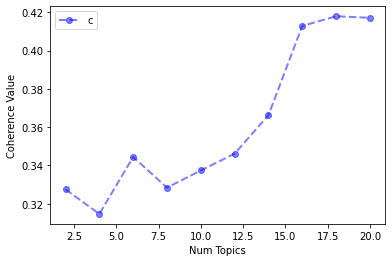

<Figure size 432x288 with 0 Axes>

In [ ]:
limit=22; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values, 'bo--', linewidth=2, markersize=6, alpha=0.5)
plt.xlabel("Num Topics")
plt.ylabel("Coherence Value")
plt.legend(("coherence_values"), loc='best')
#plt.title('Coherence Value as a function of topic numbers\n from Krebsonsecurity Title Corpus')
plt.show()
plt.savefig('Coherence_values')

In [ ]:
 for m, cv in zip(x, coherence_values):
    print('Num Topics =', m, 'has Coherence ValueErrorlue of', round(cv,4))

Num Topics = 2 has Coherence ValueErrorlue of 0.3275
Num Topics = 4 has Coherence ValueErrorlue of 0.3147
Num Topics = 6 has Coherence ValueErrorlue of 0.3444
Num Topics = 8 has Coherence ValueErrorlue of 0.3284
Num Topics = 10 has Coherence ValueErrorlue of 0.3374
Num Topics = 12 has Coherence ValueErrorlue of 0.3461
Num Topics = 14 has Coherence ValueErrorlue of 0.3663
Num Topics = 16 has Coherence ValueErrorlue of 0.4128
Num Topics = 18 has Coherence ValueErrorlue of 0.4179
Num Topics = 20 has Coherence ValueErrorlue of 0.4171


In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_chunksize in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=10, random_state=42, update_every=1, chunksize=num_chunksize, passes=10,iterations=100, alpha='auto', per_word_topics=True)
        model_list.append(model)
        coherence_model = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherence_model.get_coherence())
        
    return model_list, coherence_values

In [ ]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=df.Abstract, limit=600, start=100, step=50)

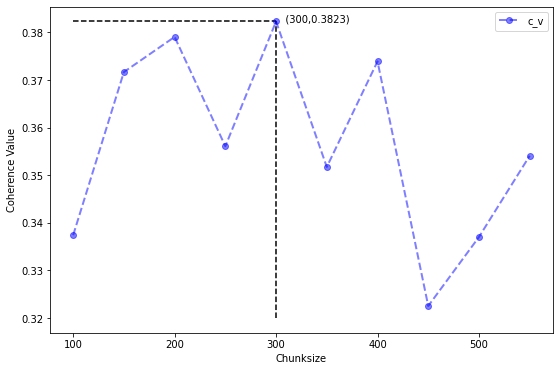

<Figure size 432x288 with 0 Axes>

In [ ]:
limit=600; start=100; step=50;
x = range(start, limit, step)
plt.figure(figsize=(9,6))
plt.plot(x, coherence_values, 'bo--', linewidth=2, markersize=6, alpha=0.5)
plt.xlabel("Chunksize")
plt.ylabel("Coherence Value")
plt.legend(["c_v"], loc='best')
a=[300]
b=[coherence_values[4]]
plt.vlines(a,0.32,b,linestyle="dashed")
plt.hlines(b,100,a,linestyle="dashed")
plt.annotate("   (300,"+str(round(coherence_values[4],4))+")",(300,coherence_values[4]))
#plt.title('Coherence Value as a function of topic numbers\n from Krebsonsecurity Title Corpus')

plt.show()
plt.savefig('Coherence_values')

In [ ]:
for m, cv in zip(x, coherence_values):
    print('chunksize =', m, 'has Coherence ValueErrorlue of', round(cv,4))

chunksize = 100 has Coherence ValueErrorlue of 0.3374
chunksize = 150 has Coherence ValueErrorlue of 0.3717
chunksize = 200 has Coherence ValueErrorlue of 0.379
chunksize = 250 has Coherence ValueErrorlue of 0.3561
chunksize = 300 has Coherence ValueErrorlue of 0.3823
chunksize = 350 has Coherence ValueErrorlue of 0.3517
chunksize = 400 has Coherence ValueErrorlue of 0.3739
chunksize = 450 has Coherence ValueErrorlue of 0.3225
chunksize = 500 has Coherence ValueErrorlue of 0.337
chunksize = 550 has Coherence ValueErrorlue of 0.3541


In [ ]:
def compute_coherence_values_passes(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_passes in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=10, random_state=42, update_every=1, chunksize=300, passes=num_passes,iterations=100, alpha='auto', per_word_topics=True)
        model_list.append(model)
        coherence_model = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherence_model.get_coherence())
        
    return model_list, coherence_values

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
model_list, coherence_values = compute_coherence_values_passes(dictionary=dictionary, corpus=corpus, texts=df.Abstract, limit=60, start=10, step=5)

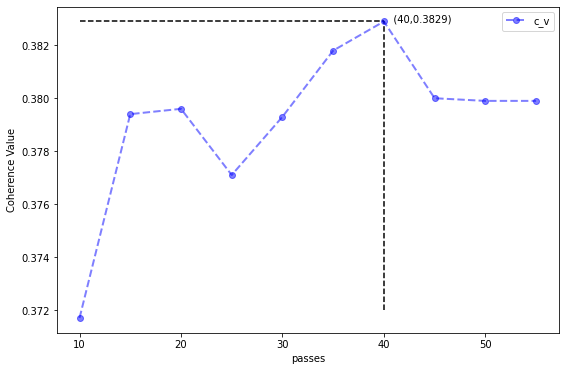

<Figure size 432x288 with 0 Axes>

In [ ]:
limit=60; start=10; step=5;
x = range(start, limit, step)
coherence_values=[0.3717,0.3794,0.3796,0.3771,0.3793,0.3818,0.3829,0.38,0.3799,0.3799]
plt.figure(figsize=(9,6))
plt.plot(x, coherence_values, 'bo--', linewidth=2, markersize=6, alpha=0.5)
plt.xlabel("passes")
plt.ylabel("Coherence Value")
plt.legend(["c_v"], loc='best')
a=[40]
b=[coherence_values[6]]
plt.hlines(b,10,a,linestyle="dashed")
plt.vlines(a,0.372,b,linestyle="dashed")
plt.annotate("   (40,"+str(coherence_values[6])+")",(40,coherence_values[6]))
#plt.title('Coherence Value as a function of topic numbers\n from Krebsonsecurity Title Corpus')
plt.show()
plt.savefig('Coherence_values')

In [ ]:
for m, cv in zip(x, coherence_values):
    print('passes =', m, 'has Coherence ValueErrorlue of', round(cv,4))

passes = 10 has Coherence ValueErrorlue of 0.3717
passes = 15 has Coherence ValueErrorlue of 0.3794
passes = 20 has Coherence ValueErrorlue of 0.3796
passes = 25 has Coherence ValueErrorlue of 0.3771
passes = 30 has Coherence ValueErrorlue of 0.3793
passes = 35 has Coherence ValueErrorlue of 0.3818
passes = 40 has Coherence ValueErrorlue of 0.3829
passes = 45 has Coherence ValueErrorlue of 0.38
passes = 50 has Coherence ValueErrorlue of 0.3799
passes = 55 has Coherence ValueErrorlue of 0.3799


In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_iter in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=10, random_state=42, update_every=1, chunksize=300, passes=40,iterations=num_iter, alpha='auto', per_word_topics=True)
        model_list.append(model)
        coherence_model = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherence_model.get_coherence())
        
    return model_list, coherence_values

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=df.Abstract, limit=600, start=100, step=50)

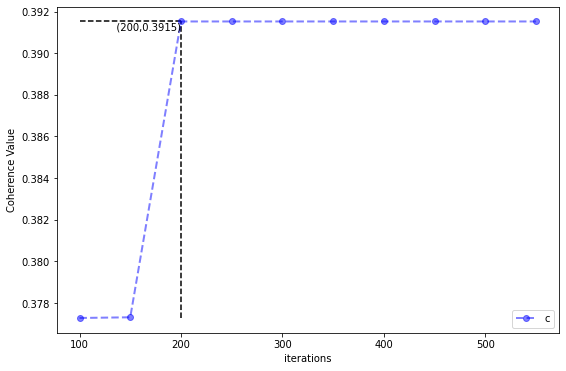

<Figure size 432x288 with 0 Axes>

In [ ]:
limit=600; start=100; step=50;
x = range(start, limit, step)
plt.figure(figsize=(9,6))
plt.plot(x, coherence_values, 'bo--', linewidth=2, markersize=6, alpha=0.5)
plt.xlabel("iterations")
plt.ylabel("Coherence Value")
plt.legend(("coherence_values"), loc='lower right')
a=[200]
b=[coherence_values[2]]
plt.hlines(b,100,a,linestyle="dashed")
plt.vlines(a,coherence_values[0],coherence_values[2],linestyle="dashed")
plt.annotate("   (200,"+str(round(coherence_values[2],4))+")",(200,coherence_values[2]),verticalalignment="top",horizontalalignment="right")
#plt.title('Coherence Value as a function of topic numbers\n from Krebsonsecurity Title Corpus')
plt.show()
plt.savefig('Coherence_values')

In [ ]:
for m, cv in zip(x, coherence_values):
    print('iterations =', m, 'has Coherence ValueErrorlue of', round(cv,4))

iterations = 100 has Coherence ValueErrorlue of 0.3773
iterations = 150 has Coherence ValueErrorlue of 0.3773
iterations = 200 has Coherence ValueErrorlue of 0.3915
iterations = 250 has Coherence ValueErrorlue of 0.3915
iterations = 300 has Coherence ValueErrorlue of 0.3915
iterations = 350 has Coherence ValueErrorlue of 0.3915
iterations = 400 has Coherence ValueErrorlue of 0.3915
iterations = 450 has Coherence ValueErrorlue of 0.3915
iterations = 500 has Coherence ValueErrorlue of 0.3915
iterations = 550 has Coherence ValueErrorlue of 0.3915


In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=42, update_every=1, chunksize=300, passes=40,iterations=200, alpha='auto', per_word_topics=True)
        model_list.append(model)
        coherence_model = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherence_model.get_coherence())
        
    return model_list, coherence_values

In [ ]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=df.Abstract, limit=22, start=2, step=2)

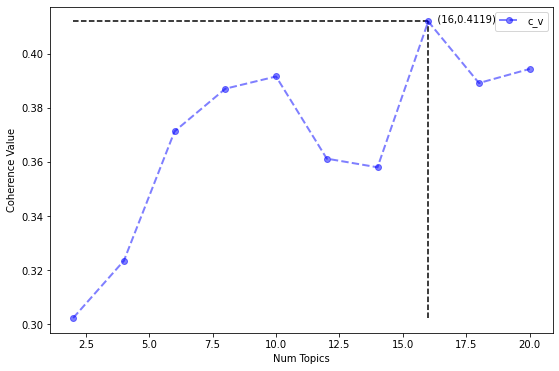

<Figure size 432x288 with 0 Axes>

In [ ]:
limit=22; start=2; step=2;
x = range(start, limit, step)
plt.figure(figsize=(9,6))
plt.plot(x, coherence_values, 'bo--', linewidth=2, markersize=6, alpha=0.5)
plt.xlabel("Num Topics")
plt.ylabel("Coherence Value")
plt.legend(["c_v"], loc='best')
a=[16]
b=[coherence_values[7]]
plt.hlines(b,2,a,linestyle="dashed")
plt.vlines(a,coherence_values[0],b,linestyle="dashed")
plt.annotate("   (16,"+str(round(b[0],4))+")",(a[0],b[0]))
#plt.title('Coherence Value as a function of topic numbers\n from Krebsonsecurity Title Corpus')
plt.show()
plt.savefig('Coherence_values')

In [ ]:
for m, cv in zip(x, coherence_values):
    print('topics =', m, 'has Coherence ValueErrorlue of', round(cv,4))

topics = 2 has Coherence ValueErrorlue of 0.3023
topics = 4 has Coherence ValueErrorlue of 0.3235
topics = 6 has Coherence ValueErrorlue of 0.3713
topics = 8 has Coherence ValueErrorlue of 0.387
topics = 10 has Coherence ValueErrorlue of 0.3915
topics = 12 has Coherence ValueErrorlue of 0.3612
topics = 14 has Coherence ValueErrorlue of 0.358
topics = 16 has Coherence ValueErrorlue of 0.4119
topics = 18 has Coherence ValueErrorlue of 0.3891
topics = 20 has Coherence ValueErrorlue of 0.3943


In [ ]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=16, random_state=42, update_every=1, chunksize=300, passes=40, iterations=200, alpha='auto', per_word_topics=True)
lda_model.print_topics()

[(0,
  '0.050*"vulnerability" + 0.034*"flaw" + 0.030*"series" + 0.022*"browser" + 0.022*"application" + 0.020*"analysis" + 0.020*"coverage" + 0.016*"storage" + 0.016*"patch" + 0.015*"engineering"'),
 (1,
  '0.051*"credit" + 0.035*"video" + 0.027*"domain" + 0.026*"cryptocurrency" + 0.022*"program" + 0.021*"researcher" + 0.021*"conspiracy" + 0.020*"demand" + 0.019*"bureau" + 0.019*"policy"'),
 (2,
  '0.064*"day" + 0.030*"page" + 0.028*"survey" + 0.025*"agency" + 0.025*"investigation" + 0.024*"article" + 0.022*"case" + 0.019*"bitcoin" + 0.018*"concept" + 0.012*"month"'),
 (3,
  '0.042*"attack" + 0.031*"traffic" + 0.019*"list" + 0.017*"bank" + 0.017*"place" + 0.015*"botnet" + 0.012*"web" + 0.011*"default" + 0.010*"internet" + 0.010*"mortgage"'),
 (4,
  '0.066*"firm" + 0.051*"fraud" + 0.019*"platform" + 0.015*"supply" + 0.015*"part" + 0.015*"review" + 0.014*"advantage" + 0.013*"solution" + 0.011*"generation" + 0.010*"morning"'),
 (5,
  '0.051*"company" + 0.050*"software" + 0.041*"access" + 

topic0: application vulnerability and flaws
topic1: cryptocurrency domain
topic2: agency investigations
topic3: botnet traffic attacks
nce
topic7: cloud network
topic8: country's economy
topic9: financial fraud
topic10: account passcode hack
topic11: ransomeware sites
topic12: encryption tools 
topic13: phone technology
topic14: organized cybercrime
topic15: identity theft and privacy issues

In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.386697  0.142108       1        1  20.289673
10     0.091070 -0.250970       2        1  10.138594
6     -0.088272  0.127620       3        1   6.950755
15    -0.093415  0.145064       4        1   6.843124
13    -0.005722  0.068713       5        1   6.435472
1      0.040131 -0.162601       6        1   5.886865
3     -0.053198 -0.026905       7        1   5.066402
7      0.053564 -0.020588       8        1   4.887049
9     -0.024716 -0.023519       9        1   4.773650
11    -0.076945  0.033995      10        1   4.746820
0     -0.052201  0.036223      11        1   4.694301
4     -0.029564 -0.041014      12        1   4.209677
12    -0.020640  0.057174      13        1   4.028125
14    -0.043720 -0.024729      14        1   3.880245
8     -0.030981 -0.048981      15        1   3.740587
2     -0.052088 -0.011592      16        1   3.428662, topic_info=          Term        Freq       Total Category  logprob  loglift
131   software  178.000000  178.000000  Default  30.0000  30.0000
45     company  185.000000  185.000000  Default  29.0000  29.0000
541      today  110.000000  110.000000  Default  28.0000  28.0000
28      access  175.000000  175.000000  Default  27.0000  27.0000
262    privacy  103.000000  103.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
1125    member    3.532893    7.021426  Topic16  -5.1471   2.6862
421     victim    4.874713   21.167543  Topic16  -4.8252   1.9046
915        web    5.205766   43.060546  Topic16  -4.7595   1.2602
644       news    4.307865   49.885924  Topic16  -4.9488   0.9237
351       hand    3.657201   13.449718  Topic16  -5.1125   2.0707

[682 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
3946     12  0.914921    Anyone
3974     12  0.914921  Internet
423       1  0.988482   ability
28        1  0.836508    access
28        2  0.051215    access
...     ...       ...       ...
906       8  0.237964     youre
906      12  0.190371     youre
906      15  0.142779     youre
1211      4  0.941907     youve
1202      8  0.963564   zeroday

[794 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 11, 7, 16, 14, 2, 4, 8, 10, 12, 1, 5, 13, 15, 9, 3])

In [ ]:
#Save the lda model from body to a pickle file
with open('lda_body.pickle', 'wb') as f:
    pickle.dump(lda_model, f)

In [ ]:
lda_model.print_topics()

[(0,
  '0.050*"vulnerability" + 0.034*"flaw" + 0.030*"series" + 0.022*"browser" + 0.022*"application" + 0.020*"analysis" + 0.020*"coverage" + 0.016*"storage" + 0.016*"patch" + 0.015*"engineering"'),
 (1,
  '0.051*"credit" + 0.035*"video" + 0.027*"domain" + 0.026*"cryptocurrency" + 0.022*"program" + 0.021*"researcher" + 0.021*"conspiracy" + 0.020*"demand" + 0.019*"bureau" + 0.019*"policy"'),
 (2,
  '0.064*"day" + 0.030*"page" + 0.028*"survey" + 0.025*"agency" + 0.025*"investigation" + 0.024*"article" + 0.022*"case" + 0.019*"bitcoin" + 0.018*"concept" + 0.012*"month"'),
 (3,
  '0.042*"attack" + 0.031*"traffic" + 0.019*"list" + 0.017*"bank" + 0.017*"place" + 0.015*"botnet" + 0.012*"web" + 0.011*"default" + 0.010*"internet" + 0.010*"mortgage"'),
 (4,
  '0.066*"firm" + 0.051*"fraud" + 0.019*"platform" + 0.015*"supply" + 0.015*"part" + 0.015*"review" + 0.014*"advantage" + 0.013*"solution" + 0.011*"generation" + 0.010*"morning"'),
 (5,
  '0.051*"company" + 0.050*"software" + 0.041*"access" + 

949


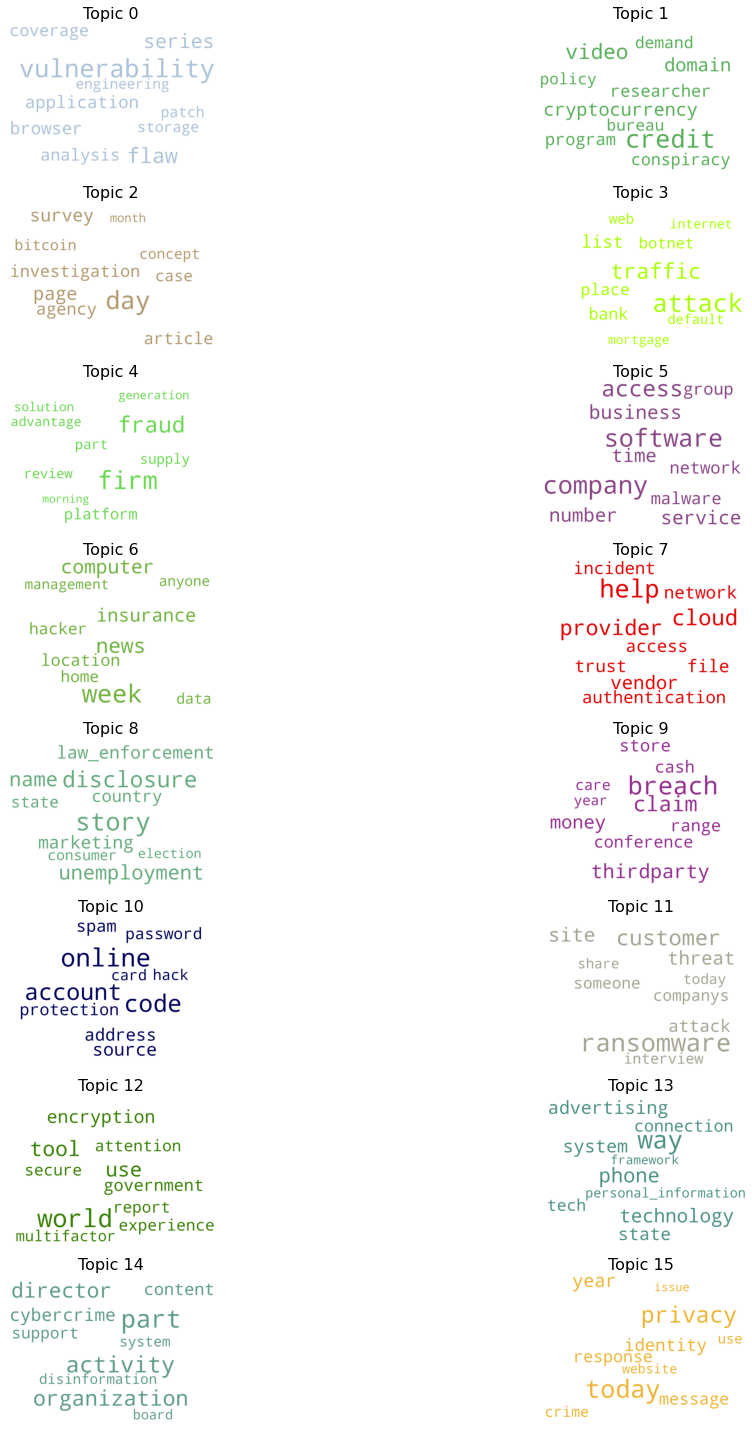

In [ ]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.XKCD_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'
print(len(cols))
cols[7]='#e50000'
cols[10]='#00035b'

cloud = WordCloud(stopwords=STOPWORDS,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False, num_topics=16)
#print(len(topics))

fig, axes = plt.subplots(8, 2, figsize=(20,20), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

Finding the dominant topic in each sentence

In [ ]:


def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [ ]:

print(type(data))

df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

<class 'list'>


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.0151,"time, password, flaw, article, patch, weakness...",One employees are working from their home netw...
1,1,0.0,0.0412,"time, password, flaw, article, patch, weakness...",The most common form of surveillance implement...
2,2,0.0,0.0207,"time, password, flaw, article, patch, weakness...",
3,3,0.0,0.0207,"time, password, flaw, article, patch, weakness...",
4,4,1.0,0.0651,"domain, morning, investigation, evidence, serv...",The main components of the security tool are t...
5,5,0.0,0.0139,"time, password, flaw, article, patch, weakness...",The key was obtained through access to the ser...
6,6,0.0,0.0207,"time, password, flaw, article, patch, weakness...",
7,7,0.0,0.0207,"time, password, flaw, article, patch, weakness...",
8,8,0.0,0.0207,"time, password, flaw, article, patch, weakness...",
9,9,0.0,0.0207,"time, password, flaw, article, patch, weakness...",


count of papers belonging to each topic

In [ ]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics.head(40)

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,0.0,"time, password, flaw, article, patch, weakness...",789.0,0.6342
1.0,0.0,"time, password, flaw, article, patch, weakness...",137.0,0.1101
2.0,0.0,"time, password, flaw, article, patch, weakness...",49.0,0.0394
3.0,0.0,"time, password, flaw, article, patch, weakness...",151.0,0.1214
4.0,1.0,"domain, morning, investigation, evidence, serv...",27.0,0.0217
5.0,0.0,"time, password, flaw, article, patch, weakness...",38.0,0.0305
6.0,0.0,"time, password, flaw, article, patch, weakness...",41.0,0.0330
7.0,0.0,"time, password, flaw, article, patch, weakness...",NaN,NaN
8.0,0.0,"time, password, flaw, article, patch, weakness...",4.0,0.0032
9.0,0.0,"time, password, flaw, article, patch, weakness...",6.0,0.0048
